In [82]:
import essentia.standard as estd
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist, squareform
from collections import OrderedDict

audioInput = 0
bpm = 0
fs = 0
path = '../audio/pain_factor-8_seconds-02-pull-88-117.mp3'



#### Get audio vector and inital tempo estimation

In [92]:
def get_audio_and_tempo(path):    
    loader = estd.AudioLoader(filename=path)
    downmixer = estd.MonoMixer()
    audioInput = loader()
    tempAudioInput, fs, num_channels, md5, bit_rate, codec = loader()
    audioInput = downmixer(tempAudioInput, num_channels)
    tempo_estimation_algo = estd.PercivalBpmEstimator(maxBPM=250, minBPM=40, sampleRate=int(fs))
    bpm = tempo_estimation_algo(audioInput)
    print(bpm, 'bpm, ', fs, 'Hz')
    return audioInput, bpm, fs

#### Compute spectrogram and 2-band energy

In [95]:
def compute_spectrogram(path):
    ## var init
    beat_duration = (60/bpm)*fs  # in samples
    frame_size = int(round(beat_duration/32))
    hop_size = round(frame_size/2)
    fft_size = int(np.power(2, np.ceil(np.log2(frame_size))))
    padding_size = fft_size - frame_size
    band1 = (1, 3000)
    if fs == 16000.0: # assuming fs is either going to be 16000 or 44100 and not any other value.
        band2 = (5443, 7619)
    elif fs == 44100.0:
        band2 = (15000, 21000)
    energy_threshold = 500.0    # the 1st energy_ratio value above this will be understood as first note in audio file

    ## get necessary Essentia algorithms
    window_algo = estd.Windowing(normalized=True, size = frame_size, type = 'hann', zeroPadding = padding_size)
    fft_algo = estd.FFT(size = fft_size)
    energy1_algo = estd.EnergyBand(sampleRate=fs, startCutoffFrequency=band1[0], stopCutoffFrequency=band1[1])
    energy2_algo = estd.EnergyBand(sampleRate=fs, startCutoffFrequency=band2[0], stopCutoffFrequency=band2[1])


    spectrogram = []
    db_spectrogram = []
    print('Frame Size:', frame_size)
    print('FFT Size:', fft_size)
    print('Padding length:', padding_size)

    first_note_flag = None
    for index, frame in enumerate(estd.FrameGenerator(audioInput, frameSize = frame_size, hopSize = hop_size, startFromZero = True)):
        ## spectrogram
        windowed_frame = window_algo(frame)
        mX = abs(fft_algo(windowed_frame))
        mX[mX<np.finfo(float).eps] = np.finfo(float).eps    # if zeros add epsilon to handle log
        dbX = 20 * np.log10(mX)
        spectrogram.append(np.array(mX))
        db_spectrogram.append(np.array(dbX))

        # energies and first note location
        energy1 = energy1_algo(mX)
        energy2 = energy2_algo(mX)
        energy_ratio = energy1/energy2
        if (first_note_flag == None) and (energy_ratio > energy_threshold):
            first_note_flag = index
            print("Found first note for frame with E1=", energy1, ", E2=", energy2, ", and E1/E2=", energy_ratio)
    spectrogram = np.array(spectrogram)
    db_spectrogram = np.array(db_spectrogram)
    print('Spectrogram done. Size is (axis1, axis2):', spectrogram.shape)
    return spectrogram, db_spectrogram, fft_size, hop_size, first_note_flag

#### Plot Spectrogram (for visual feedback only)

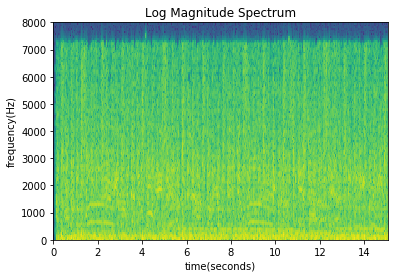

In [97]:
timeAxSec=np.arange(db_spectrogram.shape[0])*hop_size/float(fs)
freqAx_normalized=np.arange(db_spectrogram.shape[1])/float(fft_size)    #Normalized frequency axis
freqAxHz=float(fs)*freqAx_normalized

plt.pcolormesh(timeAxSec,freqAxHz,np.transpose(db_spectrogram))
plt.xlim([0,timeAxSec[-1]])
plt.ylim([0,freqAxHz[-1]])
plt.title('Log Magnitude Spectrum')
plt.ylabel('frequency(Hz)')
plt.xlabel('time(seconds)')
plt.show()

In [98]:
## time(sec) of found first note
print('First note found at time:', first_note_flag*hop_size/fs, 'seconds')

First note found at time: 0.149625 seconds


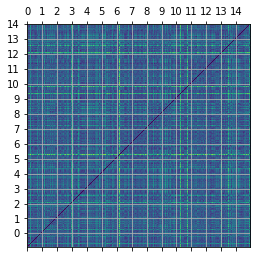

In [101]:
labels = list(range(int(len(audioInput)/fs)))
plt.matshow(ref_ASM[::-1])
stride = list(np.multiply(fs/hop_size, labels))
plt.xticks(stride, labels)
plt.yticks(stride, labels[::-1])
plt.grid(True)

In [102]:
bar_candidates = np.multiply(64, list(range(2, 13)))

In [103]:
def segment_diagonal(diagonal, bar_length):
    return [diagonal[i:i+bar_length] for i in range(0, len(diagonal), bar_length)]

In [105]:
def compute_similarity():
    ref_ASM = squareform(pdist(spectrogram[first_note_flag:]))
    diagonals = {}
    SCS = {}
    SIS = {}
    SM = {}
    for bar in bar_candidates:
        diagonals[bar] = {}
        numb_diagonals = int(ref_ASM.shape[0]/bar)
        for i in range(1, numb_diagonals+1):
            diagonals[bar][i] = list(np.diagonal(ref_ASM, bar*i))
            diagonals[bar][i] = segment_diagonal(diagonals[bar][i], bar)
        SCS[bar] = {}
        SIS[bar] = {}
        for diagonal in range(1, numb_diagonals+1):
            SCS[bar][diagonal] = []
            SIS[bar][diagonal] = []
            for segment in diagonals[bar][diagonal]:
                if len(segment) == bar:
                    SCS[bar][diagonal].append(math.sqrt(sum(list(np.power(segment, 2)))/len(segment)))
                elif len(segment) != bar:
                    SIS[bar][diagonal].append(math.sqrt(sum(list(np.power(segment, 2)))/len(segment)))
        SM[bar] = None
        scsi = 0
        sisi = 0
        sc = 0
        si = 0
        if len(diagonals[bar]) is 0:
            r = 0
        else: 
            r = len(diagonals[bar][1][-1])
        for diagonal in range(1, numb_diagonals+1):
            scsi += sum(SCS[bar][diagonal][:])
            sisi += SIS[bar][diagonal][0]
            sc += len(SCS[bar][diagonal][:])
            si += len(SIS[bar][diagonal][:])
        SM[bar] = (bar*scsi + r*sisi)/(bar*sc + r*si)
    return SM

131.57894897460938 bpm,  16000.0 Hz
Frame Size: 228
FFT Size: 256
Padding length: 28
Found first note for frame with E1= 0.10335847735404968 , E2= 0.00020094035426154733 , and E1/E2= 514.3739182400194
Spectrogram done. Size is (axis1, axis2): (2117, 129)


([<matplotlib.axis.XTick at 0x7f60ec0b5470>,
 <a list of 11 Text xticklabel objects>)

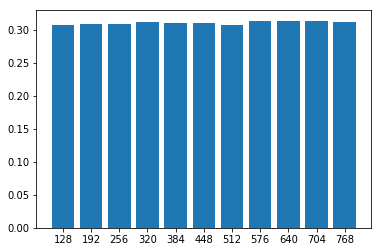

In [108]:

audioInput, bpm, fs = get_audio_and_tempo(path)
spectrogram, db_spectrogram, fft_size, hop_size, first_note_flag = compute_spectrogram(path)
SM = compute_similarity()
ordered_SM = OrderedDict(sorted(SM.items()))
plt.bar(range(len(ordered_SM)), list(ordered_SM.values()), align='center')
xlabels = list(ordered_SM.keys())
plt.xticks(range(len(ordered_SM)), xlabels)

([<matplotlib.axis.XTick at 0x7f60ec101550>,
 <a list of 11 Text xticklabel objects>)

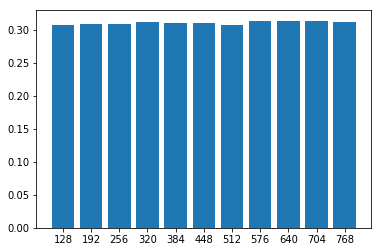

In [107]:
ordered_SM = OrderedDict(sorted(SM.items()))
plt.bar(range(len(ordered_SM)), list(ordered_SM.values()), align='center')
xlabels = list(ordered_SM.keys())
plt.xticks(range(len(ordered_SM)), xlabels)

In [77]:
top_candidate = list(SM.keys())[list(SM.values()).index(max(list(SM.values())))] / 64
if top_candidate == 2:
    time_signature = '{}/2'.format(int(top_candidate))
elif top_candidate > 2 and top_candidate < 6:
    time_signature = '{}/4'.format(int(top_candidate))
else:
    time_signature = '{}/8'.format(int(top_candidate))
print('The estimated time signature is... ', time_signature)

The estimated time signature is...  11/8
